In [1]:
# loading data

from astropy.table import Table
import numpy as np

path = "flamingo-data/l1_hydro_m8_dmo_m10.hdf5"

halos_tab = Table.read(path, path="halos")
parts_tab = Table.read(path, path="particles")

particle_pos = np.array(parts_tab["pos"], dtype=np.float64)
halo_pos = np.array(halos_tab["pos"], dtype=np.float64)
halo_mass = np.array(halos_tab["mtot"], dtype=np.float64)

particle_pos[:3], halo_pos[:3], halo_mass[:3]


(array([[679.64990234, 152.56231689, 658.51184082],
        [680.80114746, 158.16107178, 656.45654297],
        [679.72753906, 157.99188232, 656.80413818]]),
 array([[ 0.61892414, 16.90147781,  2.43126273],
        [12.09829617,  6.1280303 ,  6.2390399 ],
        [14.68611622, 13.9223814 , 11.92554665]]),
 array([5.11822570e+13, 1.26393600e+13, 7.03132493e+12]))

In [2]:
# fitting data to a periodic box

pmin = np.minimum(particle_pos.min(axis=0), halo_pos.min(axis=0))
pmax = np.maximum(particle_pos.max(axis=0), halo_pos.max(axis=0))
Lvec = pmax - pmin

# strict upper bound
Lvec = np.nextafter(Lvec.astype(np.float64), np.float64(np.inf))

# wrapping into [0, Lvec)
pp = (particle_pos - pmin) % Lvec
hp = (halo_pos - pmin) % Lvec

Lvec


array([680.99991414, 680.99991082, 681.        ])

In [3]:
# building the KD trees, boundry conditions, shell radii

from scipy.spatial import cKDTree

# per lange.
R_MIN, R_MAX = 6.0, 9.0

tree_all = cKDTree(pp, boxsize=Lvec)
tree_halo = cKDTree(hp, boxsize=Lvec)


In [4]:
# 5 - 20
# baseline mean=844.454, SEM=0.689, rel_err=0.08%
# halo mean=861.956, bias (overall) = 1.021
# bin 0: 	[1.025e+12,1.835e+12)  b=1.008
# bin 1: 	[1.835e+12,3.287e+12)  b=1.009
# bin 2: 	[3.287e+12,5.885e+12)  b=1.022
# bin 3: 	[5.885e+12,1.054e+13)  b=1.042
# bin 4: 	[1.054e+13,1.887e+13)  b=1.065
# bin 5: 	[1.887e+13,3.379e+13)  b=1.095
# bin 6: 	[3.379e+13,6.052e+13)  b=1.138
# bin 7: 	[6.052e+13,1.084e+14)  b=1.180
# bin 8: 	[1.084e+14,1.941e+14)  b=1.239
# bin 9: 	[1.941e+14,3.475e+14)  b=1.325
# bin 10: 	[3.475e+14,6.223e+14)  b=1.458
# bin 11: 	[6.223e+14,1.114e+15)  b=1.581

# 6 - 9
# baseline mean=64.386, SEM=0.173, rel_err=0.27%
# halo mean=67.246, bias (overall) = 1.044
# bin 0: 	[1.025e+12,1.835e+12)  b=1.015
# bin 1: 	[1.835e+12,3.287e+12)  b=1.016
# bin 2: 	[3.287e+12,5.885e+12)  b=1.049
# bin 3: 	[5.885e+12,1.054e+13)  b=1.093
# bin 4: 	[1.054e+13,1.887e+13)  b=1.151
# bin 5: 	[1.887e+13,3.379e+13)  b=1.219
# bin 6: 	[3.379e+13,6.052e+13)  b=1.317
# bin 7: 	[6.052e+13,1.084e+14)  b=1.423
# bin 8: 	[1.084e+14,1.941e+14)  b=1.587
# bin 9: 	[1.941e+14,3.475e+14)  b=1.769
# bin 10: 	[3.475e+14,6.223e+14)  b=2.075
# bin 11: 	[6.223e+14,1.114e+15)  b=2.586

In [5]:
# computing the random baseline. particles per particle. SEM give pretty good, rel error consistently far below 1%.

rng = np.random.default_rng(64)
N_RAND = 100000
BATCH = 10000

def batch_mean_shell(batch_pts):
    tb = cKDTree(batch_pts, boxsize=Lvec)
    cmax = tb.count_neighbors(tree_all, R_MAX)
    cmin = tb.count_neighbors(tree_all, R_MIN)
    return (cmax - cmin) / len(batch_pts)

means = []
n_done = 0
while n_done < N_RAND:
    n_take = min(BATCH, N_RAND - n_done)
    idx = rng.integers(0, len(pp), size=n_take)
    means.append(batch_mean_shell(pp[idx]))
    n_done += n_take

means = np.array(means)
mean_pp = means.mean()
sem_pp = means.std(ddof=1) / np.sqrt(len(means))
rel_err = sem_pp / mean_pp
print(f"baseline mean={mean_pp:.3f}, SEM={sem_pp:.3f}, rel_err={100*rel_err:.2f}%")


baseline mean=64.386, SEM=0.173, rel_err=0.27%


In [6]:
# computing shell neighbors around halos, bias p_halo/p_random

cmax_h = tree_halo.count_neighbors(tree_all, R_MAX)
cmin_h = tree_halo.count_neighbors(tree_all, R_MIN)
mean_ph = (cmax_h - cmin_h) / len(hp)

bias_all = mean_ph / mean_pp
print(f"halo mean={mean_ph:.3f}")
print(f"bias (overall) = {bias_all:.3f}")


halo mean=67.246
bias (overall) = 1.044


In [7]:
V_shell = (4.0*np.pi/3.0) * (R_MAX**3 - R_MIN**3)
V_sim = float(Lvec[0] * Lvec[1] * Lvec[2])
N_ptcl = len(pp)

expected_mean = N_ptcl * V_shell / V_sim
print(f"expected mean: {expected_mean:.3f}")

expected mean: 49.601


In [8]:
N_RAND = 100000
BATCH = 10000

# uniform in the periodic box [0, Lx) x [0, Ly) x [0, Lz)
def sample_uniform(n):
    u = rng.random((n, 3))
    return u * Lvec

def batch_mean_shell_uniform(n):
    pts = sample_uniform(n)
    tb = cKDTree(pts, boxsize=Lvec)
    cmax = tb.count_neighbors(tree_all, R_MAX)
    cmin = tb.count_neighbors(tree_all, R_MIN)
    return (cmax - cmin) / n

means = []
n_done = 0
while n_done < N_RAND:
    n_take = min(BATCH, N_RAND - n_done)
    means.append(batch_mean_shell_uniform(n_take))
    n_done += n_take

means = np.array(means)
mean_uniform = means.mean()
sem_uniform = means.std(ddof=1)/np.sqrt(len(means))
rel_err = sem_uniform / mean_uniform

print(f"Measured mean (uniform): {mean_uniform:.3f}  SEM={sem_uniform:.3f}  rel_err={100*rel_err:.2f}%")
print(f"Diff vs expected: {mean_uniform - expected_mean:.3f} ({100*(mean_uniform/expected_mean-1):.2f}%)")

Measured mean (uniform): 49.751  SEM=0.101  rel_err=0.20%
Diff vs expected: 0.149 (0.30%)


In [9]:
# bias versus halo mass, putting into log bins.

nbins = 12
mbins = np.logspace(np.log10(halo_mass.min()), np.log10(halo_mass.max()), nbins+1)
bin_idx = np.digitize(halo_mass, mbins) - 1

bias_bin = np.full(nbins, np.nan)
for b in range(nbins):
    sel = bin_idx == b
    if not np.any(sel):
        continue
    th = cKDTree(hp[sel], boxsize=Lvec)
    cmax = th.count_neighbors(tree_all, R_MAX)
    cmin = th.count_neighbors(tree_all, R_MIN)
    mean_ph_b = (cmax - cmin) / sel.sum()
    bias_bin[b] = mean_ph_b / mean_pp

for b in range(nbins):
    if np.isfinite(bias_bin[b]):
        print(f"bin {b}:   \t[{mbins[b]:.3e},{mbins[b+1]:.3e})  b={bias_bin[b]:.3f}")
    else:
        print(f"error by bin {b}")
        break

bin 0:   	[1.025e+12,1.835e+12)  b=1.015
bin 1:   	[1.835e+12,3.287e+12)  b=1.016
bin 2:   	[3.287e+12,5.885e+12)  b=1.049
bin 3:   	[5.885e+12,1.054e+13)  b=1.093
bin 4:   	[1.054e+13,1.887e+13)  b=1.151
bin 5:   	[1.887e+13,3.379e+13)  b=1.219
bin 6:   	[3.379e+13,6.052e+13)  b=1.317
bin 7:   	[6.052e+13,1.084e+14)  b=1.423
bin 8:   	[1.084e+14,1.941e+14)  b=1.587
bin 9:   	[1.941e+14,3.475e+14)  b=1.769
bin 10:   	[3.475e+14,6.223e+14)  b=2.075
bin 11:   	[6.223e+14,1.114e+15)  b=2.586


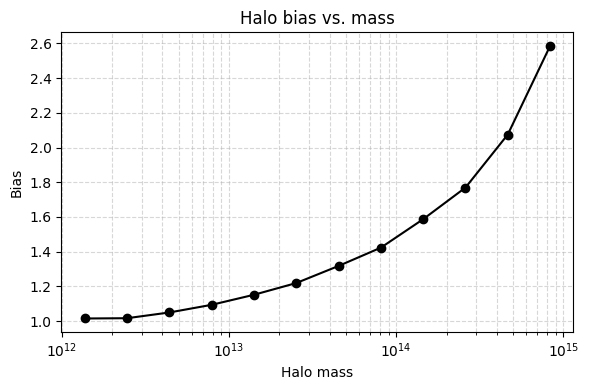

In [10]:
import matplotlib.pyplot as plt

# compute bin centers in log-space
log_mbins = np.log10(mbins)
bin_centers = 0.5 * (log_mbins[1:] + log_mbins[:-1])

# mask finite values
mask = np.isfinite(bias_bin)
x = 10**bin_centers[mask]
y = bias_bin[mask]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker="o", linestyle="-", color="k")

plt.xscale("log")
plt.xlabel("Halo mass")
plt.ylabel("Bias")
plt.title("Halo bias vs. mass")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("bias-bins.png")
plt.show()

In [11]:
HALO_BATCH = 50000

def shell_counts(points, tree_all, rmin, rmax, batch=50000):
    counts = np.empty(len(points), dtype=np.int32)
    for i in range(0, len(points), batch):
        sub = points[i:i+batch]
        # neighbors within rmax and rmin
        idx_rmax = tree_all.query_ball_point(sub, r=rmax, workers=-1)
        if rmin > 0:
            idx_rmin = tree_all.query_ball_point(sub, r=rmin, workers=-1)
            counts[i:i+batch] = np.fromiter(
                (len(a)-len(b) for a,b in zip(idx_rmax, idx_rmin)),
                dtype=np.int32, count=len(sub)
            )
        else:
            counts[i:i+batch] = np.fromiter((len(a) for a in idx_rmax),
                                            dtype=np.int32, count=len(sub))
    return counts

halo_counts = shell_counts(hp, tree_all, R_MIN, R_MAX, batch=HALO_BATCH)
halo_counts[:5], halo_counts.mean()


(array([ 80,  27,  54,  90, 119], dtype=int32), np.float64(67.24572936386834))

In [12]:
# calculating bias per indidivual halo
b_i = halo_counts / mean_pp

# poly fit in log_10 mass
logM = np.log10(halo_mass)
deg = 4
coef = np.polyfit(logM, b_i, deg=deg)
p = np.poly1d(coef)

coef


array([ 1.24065424e-01, -6.50113225e+00,  1.27745322e+02, -1.11534145e+03,
        3.65116364e+03])

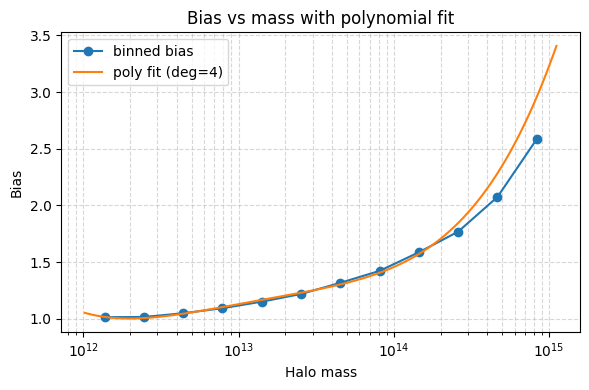

In [13]:
mask = np.isfinite(bias_bin)
x_bins = 10**bin_centers[mask]
y_bins = bias_bin[mask]

# smooth fit curve across mass range
x_fit = np.logspace(np.log10(halo_mass.min()), np.log10(halo_mass.max()), 400)
y_fit = p(np.log10(x_fit))

plt.figure(figsize=(6,4))
plt.plot(x_bins, y_bins, marker="o", linestyle="-", label="binned bias")
plt.plot(x_fit, y_fit, linestyle="-", label=f"poly fit (deg={deg})")
plt.xscale("log")
plt.xlabel("Halo mass")
plt.ylabel("Bias")
plt.title("Bias vs mass with polynomial fit")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("fit-vs-binned.png")
plt.show()


In [14]:
delta_b = b_i - p(logM)
delta_b[:5], np.nanmean(delta_b), np.nanstd(delta_b)


(array([-0.07925346, -0.73527775, -0.25263404,  0.36827465,  0.7017382 ]),
 np.float64(-5.852554544159566e-10),
 np.float64(0.5493198985455721))

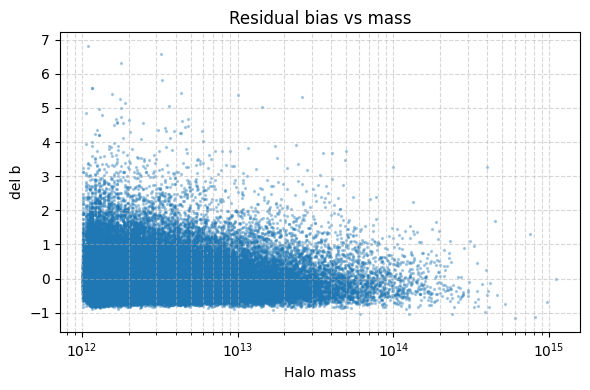

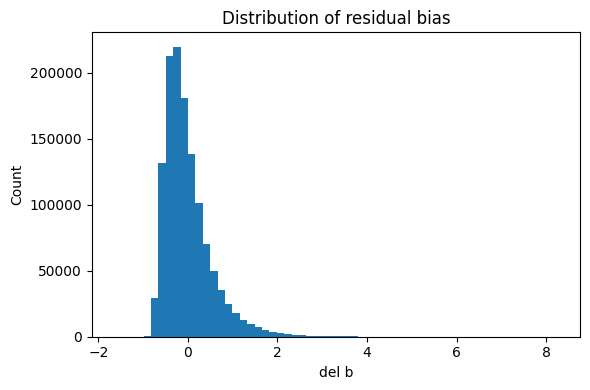

In [15]:
# scatter (downsample for visibility)
rng = np.random.default_rng(0)
show = rng.choice(len(logM), size=min(100000, len(logM)), replace=False)

plt.figure(figsize=(6,4))
plt.scatter(halo_mass[show], delta_b[show], s=2, alpha=0.3)
plt.xscale("log")
plt.xlabel("Halo mass")
plt.ylabel("del b")
plt.title("Residual bias vs mass")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("rb-v-mass.png")
plt.show()

# hist
plt.figure(figsize=(6,4))
plt.hist(delta_b, bins=60)
plt.xlabel("del b")
plt.ylabel("Count")
plt.title("Distribution of residual bias")
plt.tight_layout()
plt.savefig("dist-res.png")
plt.show()
